# Importes

Realizamos los importes necesarios para nuestro modelo

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pickle
import seaborn as sns

from ast import literal_eval
#La lista tokens en la columna tokens es en realidad una representación de una lista hecha con un string, literal_eval lo transforma en una lista real

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
import keras.backend as K

import scipy.sparse as sp
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [168]:
partes_train = []
cant_partes = 2
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_data_procesado_FILTRADO_FINAL_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/test_data_procesado_FILTRADO_FINAL.csv"
test_data = pd.read_csv(test_url)

Nos aseguramos de que se hayan importado correctamente

In [169]:
train_data.shape

(45678, 2)

In [170]:
test_data.shape

(8599, 2)

Concatenamos los tokens en una unica lista de texto y lo utilizamos para crear y entrenar el vectorizer; tanto para train como para test

In [171]:
#Transformamos train_data['tokens'] y test_data['tokens] en listas reales (antes eran representaciónes de lista hechas en string)
train_data['tokens'] = train_data['tokens'].apply(literal_eval)
test_data['tokens'] = test_data['tokens'].apply(literal_eval)

vectorizer = CountVectorizer()

corpus = [' '.join(tokens) for tokens in train_data['tokens']]
X = vectorizer.fit_transform(corpus)

corpus_test = [' '.join(tokens) for tokens in test_data['tokens']]
X_test_data = vectorizer.transform(corpus_test)

Obtenemos las etiquetas y dividivos los datos en conjunto de train y test

In [172]:
y = train_data['sentimiento'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Funciones

A Continuación, crearemos distintas funciones que serán utilizadas a lo largo del trabajo.

### mostrar_resultados

Esta función, recibe los mejores parametros encontrados, los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra las distintas metricas obtenidas del modelo.

In [173]:
def mostrar_resultados(model, best_params, X_train, y_train, X_test, y_test):
  print("Mejores hiperparámetros encontrados:", best_params)

  # Metricas en el conjunto de entrenamiento
  y_train_pred = model.predict(X_train)

  print("Métricas de evaluación en el conjunto de entrenamiento:")
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("Recall:", recall_score(y_train, y_train_pred, average='macro'))
  print("F1-Score:", f1_score(y_train, y_train_pred, average='macro'))
  print("Precision:", precision_score(y_train, y_train_pred, average='macro'))

  # Metricas en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  print("\nMétricas de evaluación en el conjunto de prueba:")
  print("Accuracy:", accuracy_score(y_test, y_test_pred))
  print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
  print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))
  print("Precision:", precision_score(y_test, y_test_pred, average='macro'))

### mostrar_matriz_confusion

La siguiuente función recibe un modelo, y los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra la matriz de confusión correspondiente para cada caso

In [174]:
def mostrar_matriz_confusion(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  cm_train = confusion_matrix(y_train, y_train_pred)

  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de entrenamiento')
  plt.show()

  print("\n\n")

  y_test_pred = model.predict(X_test)
  cm_train = confusion_matrix(y_test, y_test_pred)
  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de prueba')

  plt.show()

### get_f1

Creamos una función para que la red pueda usar el puntaje F1 como métrica

In [175]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### create_model



Creamos una funcion para crear la red. Esta tiene una capa de input, dos capas ocultas y una de output. La cantidad de neuronas de las primeras 3 capas es optimizada utilizando CrossValidation, mientras que la última solo tiene dos neuronas.


In [176]:
cant_clases=len(np.unique(y_train))

In [177]:
def create_model(optimizer='adam', activation='relu', neurons=64, neurons_2=32, neurons_3=32, neurons_4=32, neurons_5=32, regularizer=None):
  modelo = keras.Sequential([
      keras.layers.Dense(neurons, input_shape=(X_train.shape[1],), activation=activation, kernel_initializer='uniform', kernel_regularizer=regularizer),
      keras.layers.Dense(neurons_2, activation=activation, kernel_regularizer=regularizer),
      keras.layers.Dense(neurons_3, activation=activation, kernel_regularizer=regularizer),
      keras.layers.Dense(neurons_4, activation=activation, kernel_regularizer=regularizer),
      keras.layers.Dense(neurons_5, activation=activation, kernel_regularizer=regularizer),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  modelo.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', [get_f1]]
  )

  modelo.summary()

  return modelo

# Red Neuronal

A continuación procedemos a entrenar una red neuronal usando K-Fold CrossValidation. Procuramos mantener un numero de folds e iteraciones bajo debido a las limitaciones técnicas de colab.

In [178]:
param_dist = {
    'optimizer': ['adam', 'nadam'],
    'activation': ['relu', 'sigmoid'],
    'neurons': np.linspace(16,384,32),
    'neurons_2': np.linspace(16,748,64),
    'neurons_3': np.linspace(16,748,64),
    'neurons_4': np.linspace(16,748,32),
    'neurons_5': np.linspace(16,384,32),
    'regularizer': [keras.regularizers.l1(0.01), keras.regularizers.l2(0.01), keras.regularizers.l1_l2(l1=0.01, l2=0.01)]
}

modelo_cv = KerasClassifier(build_fn=create_model)
k = 2
kf = KFold(n_splits=k)

random_search = RandomizedSearchCV(
    estimator=modelo_cv,
    param_distributions=param_dist,
    n_iter=5,
    cv=kf,
    verbose=10,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 384)               5983872   
                                                                 
 dense_78 (Dense)            (None, 236)               90860     
                                                                 
 dense_79 (Dense)            (None, 457)               108309    
                                                                 
 dense_80 (Dense)            (None, 157)               71906     
                                                                 
 dense_81 (Dense)            (None, 289)               45662     
                                                                 
 dense_82 (Dense)            (None, 1)                 290       
                                                           

Luego, asignamos la cantidad de ciclos que nos interesa analizar. En nuestro caso consideramos que 10 ciclos es suficiente, ya que a continuación veremos como los gráficos muestran un crecimiento asintótico facilmente notable a la vista.

In [179]:
cant_epochs = 10

In [180]:
historia_modelo = best_model.fit(X_train_scaled, y_train, epochs=cant_epochs, batch_size=16)

y_pred_train = best_model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
scores_train = {'f1': f1_train, 'accuracy': accuracy_train, 'precision':precision_train}

y_pred_test = best_model.predict(X_test_scaled)
f1_test = f1_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
scores_test = {'f1': f1_test, 'accuracy': accuracy_test, 'precision':precision_test}

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 384)               5983872   
                                                                 
 dense_84 (Dense)            (None, 236)               90860     
                                                                 
 dense_85 (Dense)            (None, 457)               108309    
                                                                 
 dense_86 (Dense)            (None, 157)               71906     
                                                                 
 dense_87 (Dense)            (None, 289)               45662     
                                                                 
 dense_88 (Dense)            (None, 1)                 290       
                                                                 
Total params: 6,300,899
Trainable params: 6,300,899
N

In [181]:
print("Mejores hiperparámetros encontrados:", best_params)
print("Metricas en el conjunto de train:", scores_train)
print("Metricas en el conjunto de test:", scores_test)

Mejores hiperparámetros encontrados: {'regularizer': <keras.regularizers.L2 object at 0x7f67b5e3d210>, 'optimizer': 'nadam', 'neurons_5': 289.03225806451616, 'neurons_4': 157.67741935483872, 'neurons_3': 457.5238095238095, 'neurons_2': 236.76190476190476, 'neurons': 384.0, 'activation': 'relu'}
Metricas en el conjunto de train: {'f1': 0.9014274750575595, 'accuracy': 0.8995746544067055, 'precision': 0.8823317307692308}
Metricas en el conjunto de test: {'f1': 0.7997998713458652, 'accuracy': 0.7956071220081729, 'precision': 0.7820799552697791}


Viendo el puntaje F1 en train y test, podemos concluir que el modelo overfittea. Sin embargo, consideramos que está dentro de parametros aceptables, ya que en Kaggle este mismo modelo nos dio un puntaje de 0.7266, siendo así nuestra mejor red hasta el momento de entregar.

## Metricas

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6867
           1       0.78      0.82      0.80      6837

    accuracy                           0.80     13704
   macro avg       0.80      0.80      0.80     13704
weighted avg       0.80      0.80      0.80     13704

1000/1000 [==============================] - 4s 4ms/step


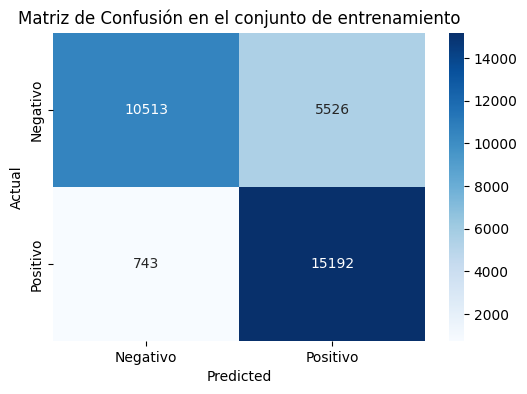




429/429 [==============================] - 1s 3ms/step


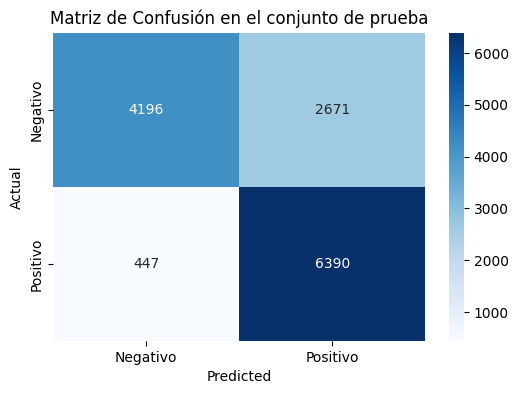

In [182]:
print(classification_report(y_test, y_pred_test))

mostrar_matriz_confusion(best_model, X_train, y_train, X_test, y_test)

Es notable que en el conjunto de prueba la precisión para los casos negativos es menor que en el de entrenamiento, mientras que el recall y la precisión de los casos positivos se mantiene aceptable.

### Gráficos

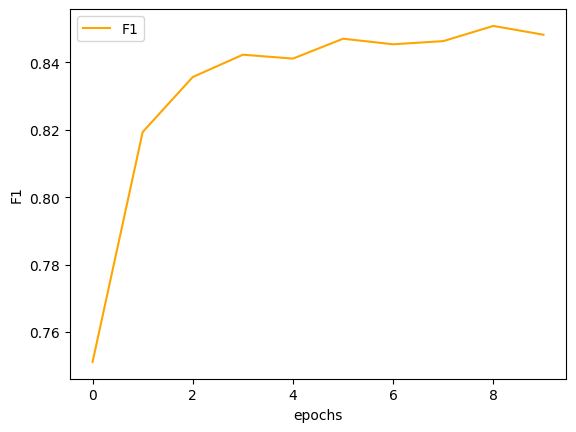

In [183]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_modelo.history['get_f1'], color='orange', label='F1')
plt.xlabel("epochs")
plt.ylabel("F1")
plt.legend()

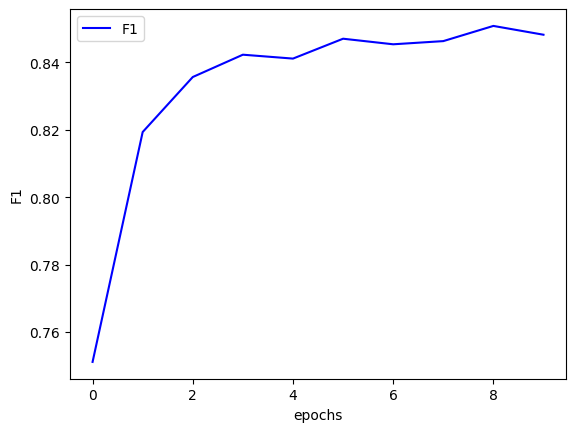

In [184]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_modelo.history['get_f1'], color='blue', label='F1')
plt.xlabel("epochs")
plt.ylabel("F1")
plt.legend()

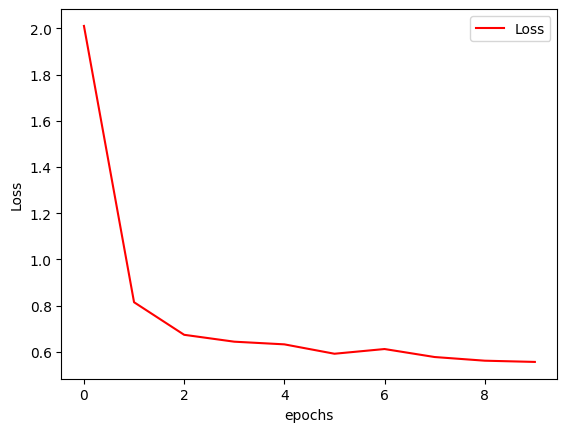

In [185]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_modelo.history['loss'], color='red', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

En los tres gráficos que realizamos es destacable el gran codo que se forma en el primer ciclo. Luego, el crecimiento de el accuracy y el puntaje F1 (y el decrecimiento de la pérdida) se vuelve asintótico a medida que se acerca al décidmo ciclo. Podemos considerar que este tipo de crecimiento se debe a la función de regularización elegida mediante la optimización de hiperparámetros, ya que esta evita el sobreajuste y que el puntaje adquiera valores surrealistas.

## Exportamos el modelo

In [189]:
with open('modelo_redn.pkl', 'wb') as file:
    pickle.dump(best_model, file)

with open('modelo_redn.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [190]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

269/269 [==============================] - 1s 4ms/step


In [191]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred.ravel()})
predictions_df.to_csv('predicciones_redn.csv', index=False)